In [142]:
%load_ext autoreload
#To update the imported files

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
%autoreload
import sys

sys.path.insert(0, '../')
from constants import *
from utilities_RF import *
from utilities import *

In [144]:
selected_features = ['date_forecast',
 'absolute_humidity_2m:gm3',
 'air_density_2m:kgm3',
 'clear_sky_energy_1h:J',
 'clear_sky_rad:W',
 'dew_or_rime:idx',
 'dew_point_2m:K',
 'diffuse_rad:W',
 'diffuse_rad_1h:J',
 'direct_rad_1h:J',
 #'direct_rad:W',
 'effective_cloud_cover:p',
 'elevation:m',
 'fresh_snow_12h:cm',
 'fresh_snow_1h:cm',
 'fresh_snow_24h:cm',
 'fresh_snow_3h:cm',
 'fresh_snow_6h:cm',
 'is_day:idx',
 'is_in_shadow:idx',
 'msl_pressure:hPa',
 'precip_5min:mm',
 'precip_type_5min:idx',
 'pressure_100m:hPa',
 'pressure_50m:hPa',
 'prob_rime:p',
 'rain_water:kgm2',
 'relative_humidity_1000hPa:p',
 'sfc_pressure:hPa',
 'snow_depth:cm',
 'snow_drift:idx',
 'snow_melt_10min:mm',
 'snow_water:kgm2',
 'sun_azimuth:d',
 'sun_elevation:d',
 'super_cooled_liquid_water:kgm2',
 't_1000hPa:K',
 'total_cloud_cover:p',
 'visibility:m',
 'wind_speed_10m:ms',
 'wind_speed_u_10m:ms',
 'wind_speed_v_10m:ms',
 'wind_speed_w_1000hPa:ms']
hyperparameters = {'max_depth': None, 'n_estimators': 100, 'n_jobs' : -1}

# Dataset A

In [145]:
selected_features_a = selected_features
hyperparameters_a = hyperparameters
X_train_a, y_train_a = prepare_data_rf_a(X_observed_a, X_estimated_a, y_a, selected_features_a)
X_test_a = prepare_testdata_rf_a(X_test_a, selected_features_a)

In [146]:
X_train_a

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad_1h:J,direct_rad:W,...,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,dif_dat_rad,hour,minute,month,time_decimal,hour_sin,hour_cos
0,7.700,1.22825,0.000000,0.000,0.0,280.299988,0.000,0.000000,0.000000,0.00,...,-3.575,-0.500,0.0,0.000000,22,0,6,22.0,-0.965926,-2.588190e-01
1,7.700,1.22350,0.000000,0.000,0.0,280.299988,0.000,0.000000,0.000000,0.00,...,-3.350,0.275,0.0,0.000000,23,0,6,23.0,-1.000000,-1.836970e-16
2,7.875,1.21975,0.000000,0.000,0.0,280.649994,0.000,0.000000,0.000000,0.00,...,-2.950,0.750,0.0,0.000000,0,0,6,0.0,-0.965926,2.588190e-01
3,8.425,1.21800,208.649994,0.750,0.0,281.674988,0.300,526.775024,0.000000,0.00,...,-2.600,0.875,0.0,0.000000,1,0,6,1.0,-0.866025,5.000000e-01
4,8.950,1.21800,32468.150391,23.100,0.0,282.500000,11.975,22068.949219,282.975006,0.15,...,-2.350,0.925,0.0,0.012526,2,0,6,2.0,-0.707107,7.071068e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34056,4.550,1.27650,84464.945312,4.225,0.0,272.424988,2.825,56431.050781,13230.649414,0.10,...,4.800,1.925,0.0,0.035398,19,0,4,19.0,-0.500000,-8.660254e-01
34057,4.500,1.27975,2270.875000,0.000,0.0,272.299988,0.000,5067.875000,176.350006,0.00,...,4.025,2.300,0.0,0.000000,20,0,4,20.0,-0.707107,-7.071068e-01
34058,4.500,1.28100,0.000000,0.000,0.0,272.299988,0.000,0.000000,0.000000,0.00,...,3.575,2.600,0.0,0.000000,21,0,4,21.0,-0.866025,-5.000000e-01
34059,4.500,1.28100,0.000000,0.000,0.0,272.299988,0.000,0.000000,0.000000,0.00,...,3.175,2.550,0.0,0.000000,22,0,4,22.0,-0.965926,-2.588190e-01


In [147]:
rf_a = Random_Forest(hyperparameters, X_train_a, X_test_a, y_train_a)

In [148]:
rf_a.cross_validate(X_train_a, y_train_a)

/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623

Cross-validation scores: [185.99773515 242.52771386 245.45270073 171.36687573 165.56354605]
Mean cross-validation score: 202.18171430607302


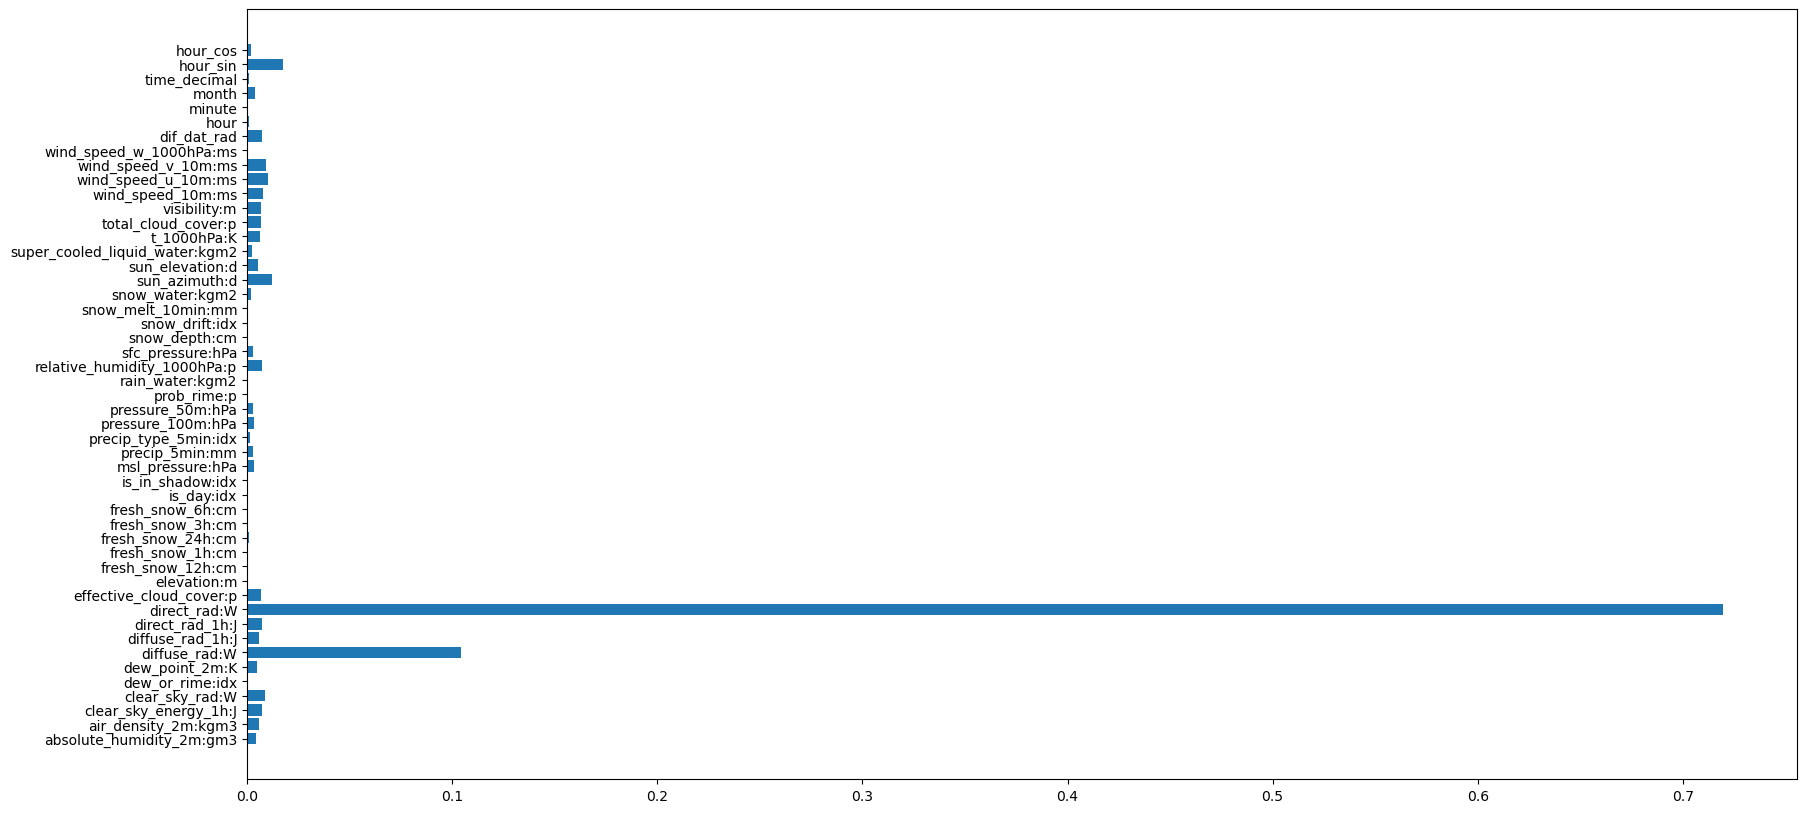

In [149]:
rf_a.fit()
rf_a.pred()
rf_a.feature_importence_plot()

# Dataset B

In [150]:
selected_features_b = selected_features
hyperparameters_b = hyperparameters
X_train_b, y_train_b = prepare_data_rf_a(X_observed_b, X_estimated_b, y_b, selected_features_b)
X_test_b = prepare_testdata_rf_a(X_test_b, selected_features_b)

In [151]:
rf_b = Random_Forest(hyperparameters_b, X_train_b, X_test_b, y_train_b)

In [152]:
rf_b.cross_validate(X_train_b, y_train_b)

/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623

Cross-validation scores: [46.65127959 22.67812972 46.61405327 19.23630375 20.23505094]
Mean cross-validation score: 31.082963452404023


/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


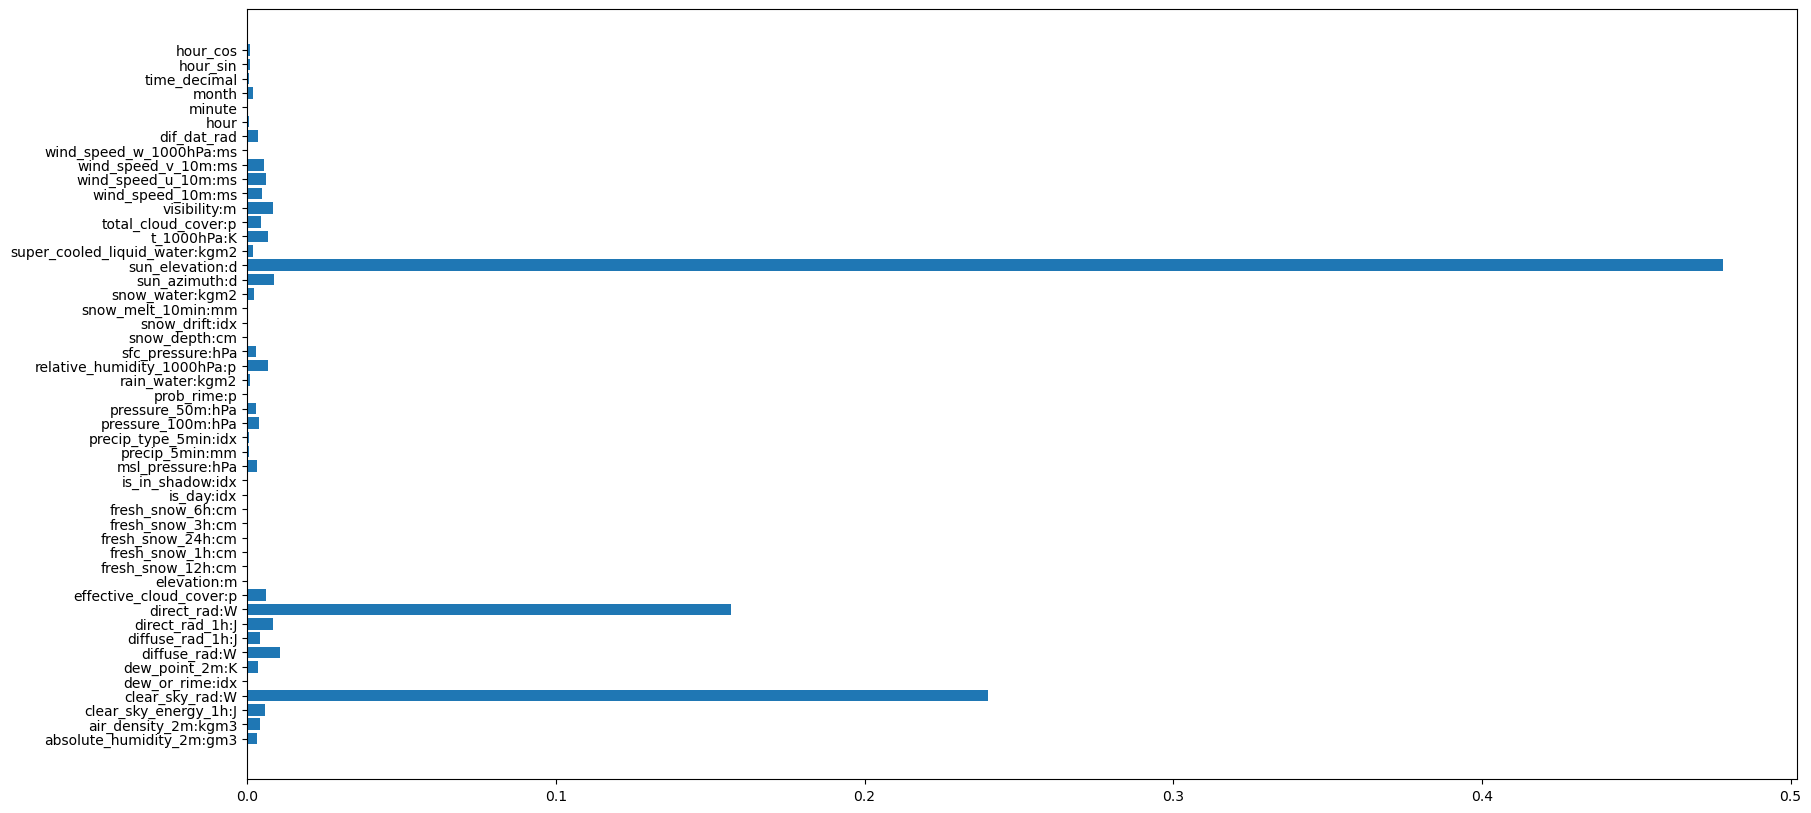

In [153]:
rf_b.fit()
rf_b.pred()
rf_b.feature_importence_plot()

# Dataset C

In [170]:
selected_features_c = selected_features
hyperparameters_c = hyperparameters
X_train_c, y_train_c = prepare_data_rf_c(X_observed_c, X_estimated_c, y_c, selected_features_c)
X_test_c = prepare_testdata_rf_c(X_test_c, selected_features_c)

In [171]:
rf_c = Random_Forest(hyperparameters, X_train_c, X_test_c, y_train_c)

In [172]:
rf_c.cross_validate(X_train_c, y_train_c)

/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623

Cross-validation scores: [15.43396018 40.44240217 23.45893482 21.6648278  23.39805447]
Mean cross-validation score: 24.879635888242724


/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [157]:
rf_c.fit()
rf_c.pred()

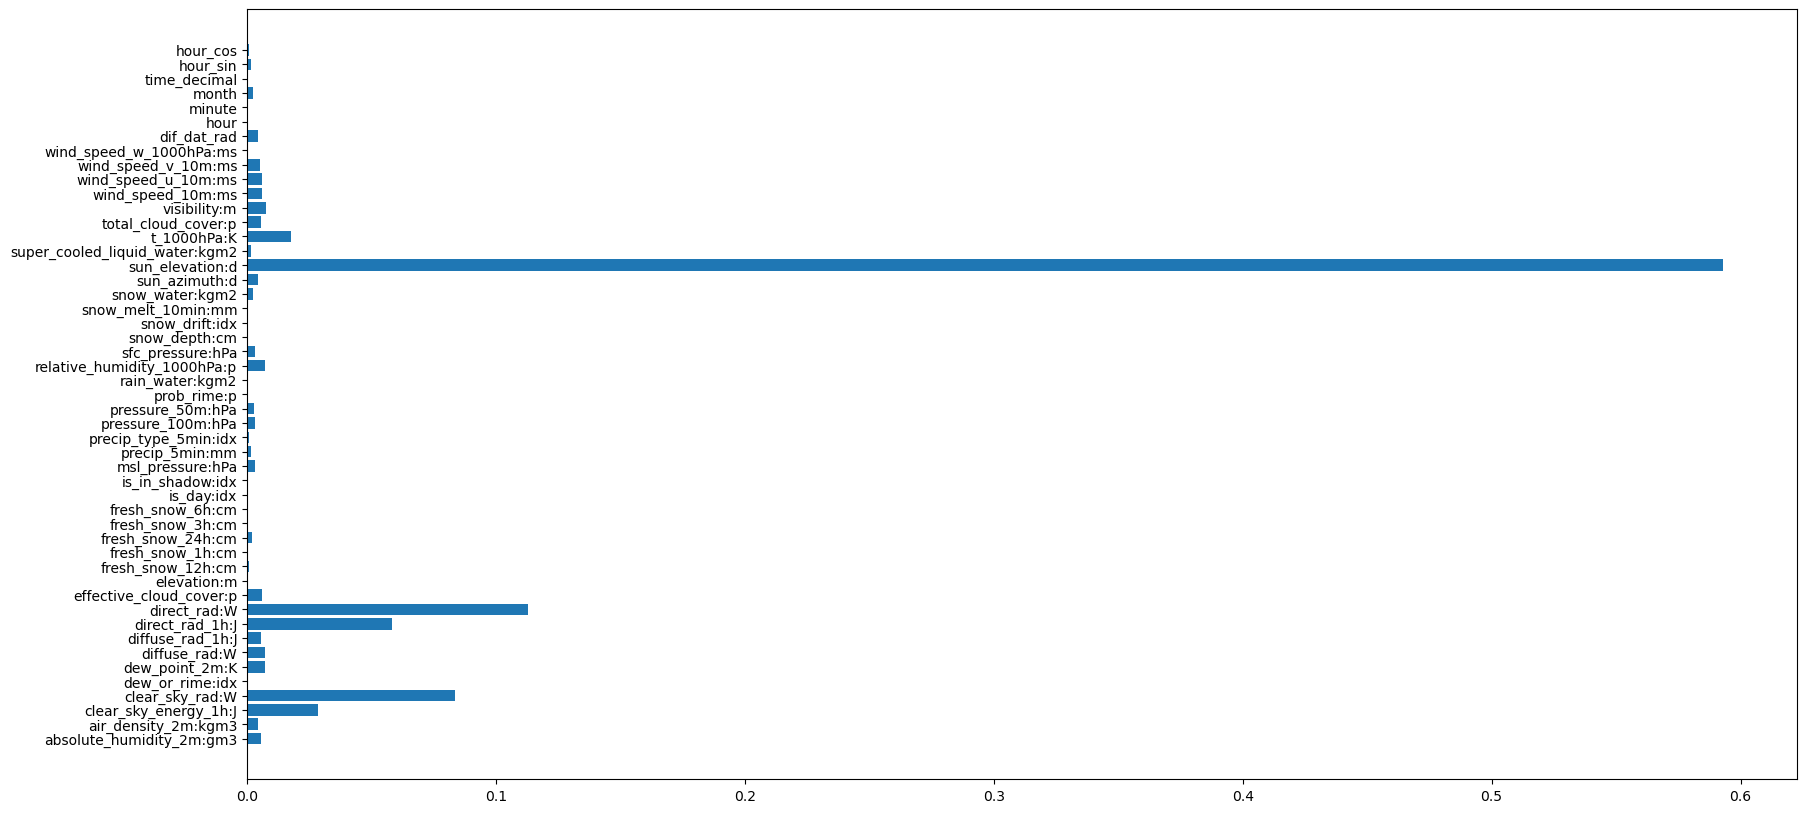

In [158]:
rf_c.feature_importence_plot()

In [159]:
y_pred_rf_test = np.concatenate((rf_a.prediction, rf_b.prediction, rf_c.prediction), axis=0)
y_pred_rf_valid = np.concatenate((rf_a.pred_estimated, rf_b.pred_estimated, rf_c.pred_estimated), axis=0)